In [1]:
#libreria para manejo de NDARRAY
import numpy as np;
import scipy as sp
#libreria para graficar
import matplotlib.pyplot as plt
#Lector de archivos csv
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import os
import sympy as sym
import pandas as pd
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import pingouin as pg
from scipy.signal import welch as pwelch

In [2]:
ruta_carpeta = '../control'

# Obtener la lista de archivos en la carpeta
lista_archivos = os.listdir(ruta_carpeta)

# Crear una matriz vacía para almacenar los datos
datos_matriz = [] # num_columnas es el número de columnas en los datos

# Iterar a través de cada archivo y agregar los datos a la matriz
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_matriz.append(senal_continua)

ruta_carpeta = '../parkinson'
lista_archivos = os.listdir(ruta_carpeta)
datos_parkinson=[]
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_parkinson.append(senal_continua)
print("Todo cargado")

Todo cargado


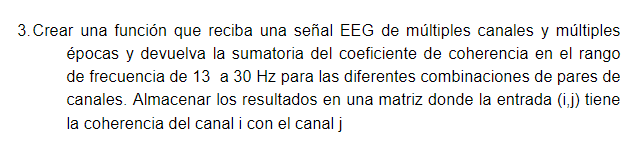

In [3]:
def deflrange(x,ini=13,end=30,fs=1000):
    N=len(x)
    f=np.linspace(0,fs,num=N)
    bf=np.where((f>=ini) &(f<=end))
    f=f[bf]
    x=x[bf]
    return f,x

In [120]:
def cohere(data1):
    canales,data=data1.shape
    cohm=np.zeros((canales,canales))
    for i in range(canales):
        for j in range(canales):
            x=np.fft.fft(data1[i])
            y=np.fft.fft(data1[j])
            _,x=deflrange(x)
            _,y=deflrange(y)
            N=len(x)
            pxy=(x*y.conj())/N
            pxx=(x**2)/N
            pyy=(y**2)/N
            den=pxx*pyy
            cohm[i][j]=np.sum(np.abs((np.abs(pxy)**2)/den))
    return cohm
            

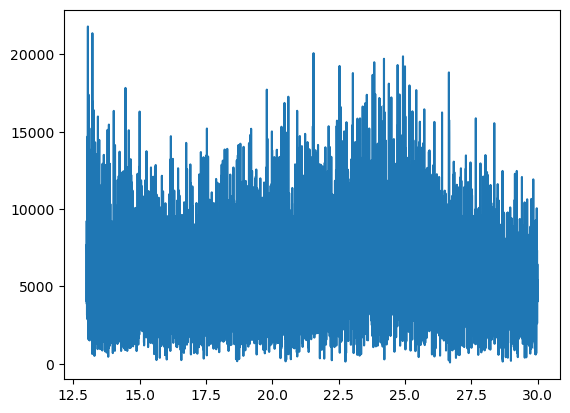

In [108]:

x=np.fft.fft(datos_matriz[0][0])
f,x=deflrange(x)
plt.plot(f,np.abs(x))
N=len(x)
pxy=(x*x.conj())/N
pxx=(x**2)/N
den=pxx*pxx
s=(np.abs(pxy)**2)/den
S=np.abs(s)


In [116]:
sum(S)

6120.0

In [34]:
np.sum(np.sqrt(signal.coherence(datos_matriz[0][0],datos_matriz[0][0])))

189.68056934059732

In [121]:
a=cohere(datos_matriz[0])

In [122]:
df=pd.DataFrame(a) #El mejor machetazo de la hisotoria
df

,0,1,2,3,4,5,6,7
0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0
1,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0
2,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0
3,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0
4,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0
5,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0
6,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0
7,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0,6120.0


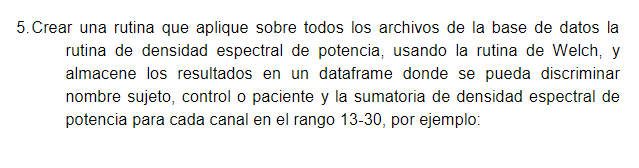

In [160]:
def PSD(data):
    fs=1000
    nperseg=len(data) 
    noverlap=0
    f,Pxx=pwelch(data,fs,"hamming",nperseg=nperseg,noverlap=noverlap)
    f,x=deflrange(Pxx,f)
    return np.sum(x)


In [166]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
"""Se crea rutina con ciclos anidados para recorrer la matriz de pacientes y los canales de cada uno de estos"""

for i in r:
    promcanales=["Control"]
    x=datos_matriz[i]
    for canales in x:
        canal=PSD(canales)
        promcanales.append(canal)
    datosprompaciente.append(promcanales)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))

for i in r:
    promcanales=["Parkinson"]
    x=datos_parkinson[i]
    for canales in x:
        canal=PSD(canales)
        promcanales.append(canal)
    datosprompaciente_p.append(promcanales)

In [167]:
names = ["Estado",'PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2'] #Los nombres de las columnas

In [168]:
df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
#Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente 
# (lista con primedio de cada canal) y el contador para identificar el paciente
for paciente in datosprompaciente: 
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
Sujeto,,,,,,,,,
1,Control,2270.501704,2462.075322,2817.841915,2230.349812,4063.540359,3106.339751,2855.573161,2867.226187
2,Control,2130.222117,2475.567217,2950.324800,2744.419165,2305.721043,14547.205761,9940.380475,10893.466230
3,Control,1465.590539,2237.115611,3571.685593,1738.236300,3581.339365,1700.299311,1849.488307,2219.313965
4,Control,3782.789154,4353.544683,4956.599062,4424.209949,3815.365734,14738.395146,14700.468603,15374.747021
5,Control,1989.874064,2237.371938,2493.828107,2612.861588,2785.905544,7336.613560,5207.067344,5941.586794
6,Control,1485.024309,1743.665479,2029.135740,1467.200145,1717.910783,3646.816677,2926.946627,2875.504980
7,Control,1101.431701,1022.120666,1180.735768,989.583609,907.853532,2421.443852,1757.452753,3207.814314
8,Control,4235.311501,4027.027676,2406.936709,2442.691666,3576.080066,14259.431026,8087.607539,10840.781447
9,Control,1316.571008,1306.057299,1668.905745,1514.055945,1481.355212,6790.888224,6887.095192,7492.960639


In [153]:
df.to_csv("Tabla.cvs",index=False)

In [156]:
df=pd.read_csv("Tabla.cvs")

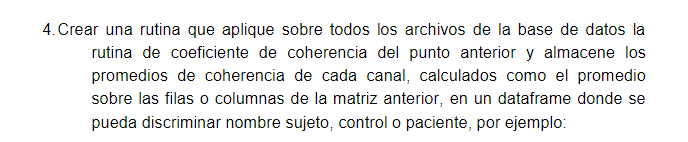

In [79]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
"""Se crea rutina con ciclos anidados para recorrer la matriz de pacientes y los canales de cada uno de estos"""

for i in r:
    promcanales="Control"
    x=cohere(datos_matriz[i])
    x=x.mean(0).tolist()
    x.insert(0,promcanales)
    datosprompaciente.append(x)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))

for i in r:
    promcanales="Parkinson"
    x=cohere(datos_matriz[i])
    x=x.mean(0).tolist()
    x.insert(0,promcanales)
    datosprompaciente_p.append(x)

In [62]:
names = ["Estado",'Coherencia_promedio_PSD_C3', 'Coherencia_promedio_PSD_C1', 'Coherencia_promedio_PSD_CZ', 'Coherencia_promedio_PSD_C2', 'Coherencia_promedio_PSD_C4', 'Coherencia_promedio_PSD_O1', 'Coherencia_promedio_PSD_OZ', 'Coherencia_promedio_PSD_O2'] #Los nombres de las columnas

In [80]:
df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
#Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente 
# (lista con primedio de cada canal) y el contador para identificar el paciente
for paciente in datosprompaciente: 
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,Coherencia_promedio_PSD_C3,Coherencia_promedio_PSD_C1,Coherencia_promedio_PSD_CZ,Coherencia_promedio_PSD_C2,Coherencia_promedio_PSD_C4,Coherencia_promedio_PSD_O1,Coherencia_promedio_PSD_OZ,Coherencia_promedio_PSD_O2
Sujeto,,,,,,,,,
1,Control,0.779229,0.706570,0.477474,0.411181,0.507375,1.777748,0.812578,0.426279
2,Control,1.384965,4.211007,2.500988,2.236538,1.573231,1.452441,1.479783,1.323877
3,Control,1.865428,2.258124,27.830037,6.828831,33.515416,2.005095,2.293310,8.198615
4,Control,0.762720,0.367269,0.190276,0.171178,0.382055,0.631820,0.433496,0.239163
5,Control,1.320257,2.883370,3.082877,1.877798,3.657041,0.692821,0.601340,0.681017
6,Control,1.277845,0.921450,1.245920,1.230755,0.776380,2.658390,3.291179,4.182026
7,Control,4.075266,1.981138,3.522073,129.554694,3.196633,2.138501,1.944933,1.337053
8,Control,0.690937,0.709747,0.529269,1.075797,1.955113,0.496347,1.022709,0.653746
9,Control,0.527821,0.382339,0.389259,0.395654,0.442327,2.341572,0.714470,0.395839


In [81]:
df.to_csv("Tabla_coherencia.cvs",index=False)

In [ ]:
df2=pd.read_csv("Tabla.cvs")